# Feature Selection

* Keep 욕설
* Delete one letter words (No meaning)
* Delete 생소한 words
* Keep Noun, Adjective, Verb, KoreanParticles
* Information Gain

In [22]:
import pandas as pd
import csv
import os
from collections import defaultdict

In [9]:
allassult = []
with open('./dataset/assult.csv','r',encoding='utf-8') as readfile:
    reader = csv.reader(readfile)
    for row in reader:
        word = False
        for ch in row[0]:
            try:
                ch.encode('ascii')
                word = True
            except:
                pass
        if not word:
            allassult.append(row[0])

In [10]:
with open('./dataset/assult2.csv','w',newline='\n',encoding='utf-8') as writefile:
    writer = csv.writer(writefile)
    for assult in allassult:
        writer.writerow([assult])

## 모든 단어 set 확인 및 욕설 단어 갯수 확인

* 욕 DB에 있는 1439개 단어 중 506개가 사용됨

In [12]:
allword = set()

In [13]:
filepath = './dataset/user_result3/'
files = os.listdir(filepath)
for file in files:
    with open(filepath+file,'r',encoding='utf-8') as readfile:
        reader = csv.reader(readfile)
        for row in reader:
            allword.add(row[0])

In [14]:
len(allword)

233090

In [20]:
assult_set = set(allassult)
len(assult_set)

1439

In [21]:
len(allword & assult_set)

506

---

## 한글자 짜리, 형태소 의미 없는 것들 삭제 + 욕 db에 있으면 남기기

* Noun, Verb, Adjective, KoreanParticle 만 남기기
* 1글자 짜리 삭제

In [81]:
filepath = './dataset/user_result2/'
files = os.listdir(filepath)
all_result = defaultdict(lambda:"")
for file in files:
    with open(filepath+file,'r',encoding='utf-8') as readfile:
        reader = csv.reader(readfile)
        game_id = int(file.split('.')[0])
        for row in reader:
            pos = row[1]
            if row[0] in assult_set:
                for i in range(0,int(row[2])):
                    all_result[game_id]+=(row[0]+" ")
            elif pos in (["Noun","Verb","Adjective","KoreanParticle"]):
                if len(row[0])>1:
                    for i in range(0,int(row[2])):
                        all_result[game_id]+=(row[0]+" ")


라벨링 후 저장

In [82]:
a_list = []
f_list = []
with open('./dataset/cbt5_label.csv','r',encoding='utf-8') as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for row in reader:
        if row[1]=='A':
            a_list.append(int(row[0]))
        else:
            f_list.append(int(row[0]))

In [83]:
allword = set()

In [84]:
with open('./dataset/cbt5_corpus3000.csv','w',newline='\n',encoding='utf-8') as writefile:
    writer = csv.writer(writefile)
    writer.writerow(['game_id','corpus','label'])
    for game_id in all_result.keys():
        if game_id in a_list:
            for w in all_result[game_id].split(' '):
                allword.add(w)
            writer.writerow([game_id,all_result[game_id],'a'])
        elif game_id in f_list:
            writer.writerow([game_id,all_result[game_id],'f'])
            for w in all_result[game_id].split(' '):
                allword.add(w)

In [85]:
len(allword)

41548

# Make Bow

In [165]:
data = pd.read_csv('./dataset/cbt5_corpus.csv')
data.head()

,game_id,corpus,label
0,1001,놓치는 시기 시기 야할 계신 계신 사태 교훈 왕관 오래 오래 오래 오래 회수 회수 ...,a
1,10014,인생 인생 있다 같은 랩때 날틀 날틀 싶은 지랄 지랄 지랄 지랄 쉬발 당연한 열매 ...,f
2,10037,렉쩌는데 문제 추자 춤좀 김정 겜톡 겜톡 겜톡 겜톡 겜톡 안되는 셔플 셔플 셔플 쩐...,f
3,10185,나뭇가지 어렵 제발 몽상 몽상 몽상 사서 상어 상어 구하는 구하는 하다 죽엿는데 죽...,a
4,10230,찾기 ㅇㅋㅇㅋ 나지 어딧는 잠긴 업데이트 파티 좀덜 마우스 마우스 마우스 마우스 개...,f


In [166]:
from sklearn.feature_extraction.text import CountVectorizer

In [167]:
def make_review_bow(data):    
   
    vectorizer = CountVectorizer(min_df=0)

    doc = []
    
    for text in data['corpus']:
        doc.append(text)
    vectorizer.fit(doc)
    x = vectorizer.transform(doc)
    bow2 = x.toarray()
    bow = pd.DataFrame(bow2,columns=vectorizer.vocabulary_.keys())

    return vectorizer, bow

In [168]:
vectorizer, X = make_review_bow(data)

In [169]:
X.head()

,놓치는,시기,야할,계신,사태,교훈,왕관,오래,회수,아쉬운,...,죧망함,하늘가,법니,담업,워주,덴슬로로,치셧어야,명있었꼬,산닷,루틸
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
Y = data.label

In [171]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

In [174]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * sgd.score(x_test, y_test))
print (cm)
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * nb.score(x_test, y_test))
print (cm)
lg = LogisticRegression()
lg.fit(x_train,y_train)
y_pred = lg.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * lg.score(x_test, y_test))
print (cm)

Model Accuracy: 94.5686900958
[[145   8]
 [  9 151]]
Model Accuracy: 59.7444089457
[[153   0]
 [126  34]]
Model Accuracy: 95.8466453674
[[140  13]
 [  0 160]]


---

# using first 3000 words

In [175]:
data = pd.read_csv('./dataset/cbt5_corpus3000label.csv')
data.head()

,game_id,corpus,label
0,1001,교훈 시기 시기 계신 계신 사태 놓치는 오래 오래 오래 오래 이상 아쉬운 해주시 사...,a
1,10014,인생 인생 만세 있다 같은 랩때 날틀 날틀 싶은 지랄 지랄 지랄 지랄 쉬발 먹엇어 ...,f
2,10037,문제 추자 춤좀 겜톡 겜톡 겜톡 겜톡 겜톡 안되는 셔플 셔플 셔플 쩐다 맨손 마리 ...,f
3,10185,하셧 가기 계신 보고 싶은 짜증 짜증 약간 육식 육식 육식 육식 육식 육식 육식 육...,a
4,10230,찾기 ㅇㅋㅇㅋ 나지 개사 잡으 여기 여기 여기 여기 여기 잠긴 업데이트 파티 좀덜 ...,f


In [176]:
vectorizer, X = make_review_bow(data)
Y = data.label
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

In [178]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * sgd.score(x_test, y_test))
print (cm)
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * nb.score(x_test, y_test))
print (cm)
lg = LogisticRegression()
lg.fit(x_train,y_train)
y_pred = lg.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * lg.score(x_test, y_test))
print (cm)


Model Accuracy: 94.8881789137
[[139   7]
 [  9 158]]
Model Accuracy: 92.9712460064
[[146   0]
 [ 22 145]]
Model Accuracy: 95.2076677316
[[136  10]
 [  5 162]]


In [116]:
X.head()

,교훈,시기,계신,사태,놓치는,오래,이상,아쉬운,해주시,사이좋,...,수익금,ㅣㅓ,은괴듬,빠빠밤,명있었꼬,나다물량,ㅇㄹㄴㅇㄹ,선창,리익,ㅜㄴㅁㅇㄹ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Cut TF below 10 words

In [179]:
words1 = pd.read_csv('./dataset/tfidf_more10_a.csv')
words2 = pd.read_csv('./dataset/tfidf_more10_f.csv')

In [180]:
words1.head()

,word,tf-idf,tf
0,시기,1.214665,19
1,계신,1.850684,95
2,오래,1.875265,101
3,이상,2.197838,225
4,해주시,1.193867,18


In [181]:
words1 = set(words1.word)
words2 = set(words2.word)

In [182]:
words3 = set(X.columns)

In [183]:
word_list = list((words1 | words2)&words3)
len(word_list)

4109

In [184]:
X_2 = X[word_list]

In [209]:
vectorizer, X_2 = make_review_bow(data)
Y = data.label
x_train, x_test, y_train, y_test = train_test_split(X_2,Y,test_size=0.3)

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * sgd.score(x_test, y_test))
print (cm)
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * nb.score(x_test, y_test))
print (cm)
lg = LogisticRegression()
lg.fit(x_train,y_train)
y_pred = lg.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print ("Model Accuracy:", 100 * lg.score(x_test, y_test))
print (cm)


Model Accuracy: 94.8881789137
[[153   2]
 [ 14 144]]
Model Accuracy: 93.9297124601
[[155   0]
 [ 19 139]]
Model Accuracy: 96.8051118211
[[147   8]
 [  2 156]]


In [217]:
import operator

rank_sort = sorted(rank.items(), key=operator.itemgetter(1))

In [225]:
rank_sort[:20]

[('왓엇음아까', -0.36933042326327981),
 ('기억나시', -0.34176148766888553),
 ('심느', -0.31787785184912193),
 ('눌려봐', -0.27992123920726042),
 ('병헌', -0.26798251061236678),
 ('터보', -0.25918237283512491),
 ('쾌꺠', -0.25301726881625997),
 ('장의', -0.25172750277346495),
 ('돈줘잉', -0.2435215772879305),
 ('졸업', -0.24350618711943248),
 ('엄청쎔', -0.23539267526125809),
 ('찍힘', -0.22778153586599842),
 ('볼라', -0.22520670883696897),
 ('딱퍼임', -0.2244750272072227),
 ('모비', -0.22178627735941833),
 ('글픽글픽', -0.21786441721969713),
 ('보름달', -0.2172650123431013),
 ('달라짐', -0.21646262323450363),
 ('적용되는', -0.21257769956464734),
 ('스릇', -0.20410323380442313)]

In [224]:
rank_sort[-20:]

[('추고', 0.18597711133291603),
 ('낱틀', 0.18689764221194111),
 ('파티뎀지', 0.18896183311681691),
 ('지드래곤', 0.1891742242860926),
 ('싸우기', 0.19100943939961793),
 ('삑살', 0.19147741704721877),
 ('추가될', 0.19155956169882885),
 ('커졋', 0.19768686082593032),
 ('쓰러지', 0.20005559928220376),
 ('우걱', 0.20040974095067463),
 ('개새키', 0.20883316357774068),
 ('빡시겟군', 0.21879219234630404),
 ('왜배', 0.22424717629138832),
 ('교배', 0.23596548369521914),
 ('춤추던', 0.24923783438684174),
 ('어찌하지', 0.26240823393672036),
 ('입어봤', 0.26858836119727553),
 ('맞추셔', 0.29592821668684083),
 ('와우', 0.30521484438232521),
 ('걸렷는데', 0.40676794264676119)]

In [99]:
from sklearn.feature_selection import mutual_info_classif
import operator

In [96]:
res = dict(zip(X.columns, mutual_info_classif(x_train, y_train, discrete_features=True)))

In [104]:
sorted_x = sorted(res.items(), key=operator.itemgetter(1),reverse=False)

---

# 욕설 카운트

In [106]:
len(allassult)

1480

In [108]:
with open('./dataset/cbt5_corpus3000label.csv','r',encoding='utf-8') as readfile:
    reader = csv.reader(readfile)
    next(reader)
#     writer.writerow(['game_id','corpus','label'])
    with open('./dataset/cbt5_assultstat.csv','w',newline='\n') as writefile:
        writer = csv.writer(writefile)
        writer.writerow(['game_id','label','count'])
        for row in reader:
            words = row[1].split(' ')
            count = 0
            for word in words:
                if word in allassult:
                    count+=1
            writer.writerow([row[0],row[2],count])

In [118]:
assult_data = pd.read_csv('./dataset/cbt5_assultstat.csv')
assult_data.head()

,game_id,label,count
0,1001,a,3
1,10014,f,7
2,10037,f,8
3,10185,a,1
4,10230,f,4


In [120]:
data_a = assult_data.loc[assult_data.label=='a']
data_f = assult_data.loc[assult_data.label=='f']

In [121]:
import matplotlib.pyplot as plt

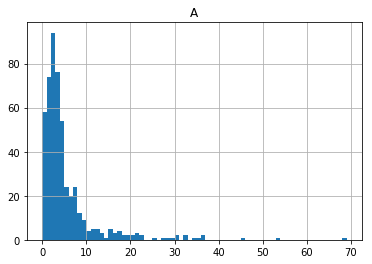

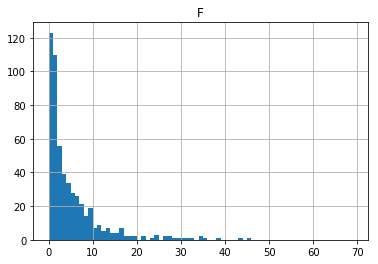

In [131]:

data_a['count'].hist(bins=range(0,70,1))
plt.title("A")
plt.show()

data_f['count'].hist(bins=range(0,70,1))
plt.title("F")
plt.show()